In [1]:
#!pip install h5py==3.1.0
! pip install sklearn matplotlib pillow --quiet

In [2]:
import tensorflow as tf
#import keras
from tensorflow import lite

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50,inception_v3,nasnet
from sklearn.utils import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from IPython.display import clear_output
from tensorflow import keras
import time
import datetime

import shutil

from tensorflow.compat.v1 import ConfigProto,InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Metal device set to: Apple M1


2022-04-05 18:20:39.989397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-05 18:20:39.989508: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
#copy no disease imgs to train/validation folder
src = "/Users/casiana/Documents/SkinCancer/input/nod/"
prefix = "/Users/casiana/Documents/SkinCancer/input/datatree/" 
dst_dir = "train/nod"

x=0
for file in os.listdir(src):
    #print(file)
    shutil.copy(src+file, prefix+dst_dir)
    x += 1
    if(x == int(0.7 * len([name for name in os.listdir(src)]))):
        dst_dir = "test/nod"
        
    elif(x == int(0.85 * len([name for name in os.listdir(src)]))):
        dst_dir = "validation/nod"

500_F_70043386_2r7XNMaTckpXjPBhy2bYzXWgJ7XhCNi5.jpg
image22.jpeg
500_F_209785320_crUmCEVAiKJuigpjQZKIyjSsnmJkDzAg.jpg
500_F_202435479_mIKqJWZBphzXYjAqGB2XGANIDOWcecoG.jpg
image0.jpeg
texture-human-skin-macro-close-up-background-103142130.jpg
gczIJP.jpg
image18.jpeg
structure-human-skin-layer-isolated-600w-1321668554.jpg
human-skin-background-closeup-texture-60933701.jpg
fb_32x32.png
human-skin-stock-illustrations_csp11585673.jpg
bemoll190100001.jpg
500_F_206309170_tUIlW1Q4DLfBUm544dVqLTASelWH1Nql.jpg
500_F_270036617_UPjWqPLe1lRncGNaJ9fTpQSTyDM68cAS.jpg
15010609-human-skin-background.jpg
human-skin-vector-background-600w-1289574262.jpg
macro-pink-skin-texture-human-background-close-up-105956295.jpg
depositphotos_104373978-stock-photo-textured-packaging-paper-background.jpg
human-skin-background-stock-photo-2518301.jpg
image14.jpeg
2856248-elegant-hands-on-neutral-background-woman-human-being-photocase-stock-photo-large.jpeg
image15.jpeg
desktop_searchbox_sprites302_hr.webp
240_F_2105645

In [4]:
print('Number of train samples')
file_path = prefix + 'train/'
N = 0  # total files
for dirpath, dirnames, filenames in os.walk(file_path):
    N_c = len(filenames)
    N += N_c
    print ("Files in ", dirpath, N_c)
print ("Total Files ",N)

Number of train samples
Files in  /Users/casiana/Documents/SkinCancer/input/datatree/train/ 1
Files in  /Users/casiana/Documents/SkinCancer/input/datatree/train/akiec 3990
Files in  /Users/casiana/Documents/SkinCancer/input/datatree/train/df 2810
Files in  /Users/casiana/Documents/SkinCancer/input/datatree/train/bkl 3855
Files in  /Users/casiana/Documents/SkinCancer/input/datatree/train/vasc 3490
Files in  /Users/casiana/Documents/SkinCancer/input/datatree/train/nv 4023
Files in  /Users/casiana/Documents/SkinCancer/input/datatree/train/bcc 3610
Files in  /Users/casiana/Documents/SkinCancer/input/datatree/train/nod 107
Files in  /Users/casiana/Documents/SkinCancer/input/datatree/train/mel 3895
Total Files  25781


In [5]:
#augment train data
train_datagen = ImageDataGenerator(rescale=1./255)

x_train = train_datagen.flow_from_directory(
    directory=prefix + 'train/',
    batch_size=32,
    target_size=(224,224),
    class_mode="categorical",
    shuffle=True,
    seed=42
)
train_generator = x_train
classes = train_generator.classes

#compute balanced class weights
class_weights = compute_class_weight(
                                    class_weight = "balanced",
                                    classes = np.unique(classes),
                                    y = classes                                                    
                                    )
class_weights = dict(zip(np.unique(classes), class_weights))

print("\n class_weights =",  class_weights)

Found 25778 images belonging to 8 classes.

 class_weights = {0: 0.8075814536340852, 1: 0.8925900277008311, 2: 0.8358625162127108, 3: 1.1467081850533807, 4: 0.8272785622593068, 5: 30.688095238095237, 6: 0.8009569972657221, 7: 0.9232808022922636}


In [8]:
validation_datagen = ImageDataGenerator(rescale=1./255)

x_validation = validation_datagen.flow_from_directory(
    directory=prefix+ 'validation/',
    batch_size=32,
    target_size=(224,224),
    class_mode="categorical",
    shuffle=True,
    seed=42
)
validation_generator = x_validation
classes = validation_generator.classes
compute_class_weight(
                    class_weight = "balanced",
                    classes = np.unique(classes),
                    y = classes                                                    
                    )
class_weights_val = dict(zip(np.unique(classes), class_weights))

print("class_weights_val = ",  class_weights_val)

Found 2023 images belonging to 8 classes.
class_weights_val =  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}


In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

x_test = test_datagen.flow_from_directory(
    directory=prefix+'test/',
    batch_size=32,
    target_size=(224,224),
    class_mode="categorical",
    shuffle=False,
    seed=42
)

test_generator = x_test

Found 2023 images belonging to 8 classes.


In [10]:
num_train_samples = train_generator.n
num_val_samples = validation_generator.n
train_batch_size = 256
val_batch_size = 256

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
print(train_steps)
print(val_steps)

101.0
8.0


(224, 224, 3)


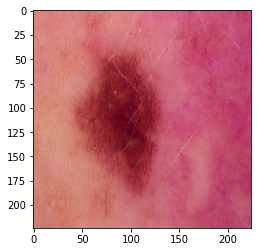

In [14]:
p = x_train.next()
print((p[0][0]).shape)
(plt.imshow(p[0][0][:,:,:]) )

In [15]:
lr =0.0001
def create_inception_model2(n_classes=8,learning_rate=lr):
    raw_model = keras.applications.inception_v3.InceptionV3(include_top=False, 
                                                            weights='imagenet', 
                                                            input_shape=(224,224,3), 
                                                            classes=n_classes)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
    #for layer in raw_model.layers:
    #    layer.trainable = False
    full_model = Sequential()
    full_model.add(raw_model)
    full_model.add(GlobalAveragePooling2D())
    full_model.add(Dropout(0.2))
    full_model.add(Dense(512,activation='relu'))
    full_model.add(Dropout(0.1))
    full_model.add(Dense(8, activation = 'softmax'))
    full_model.compile(Adam(lr=learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    full_model.summary()
    return full_model

In [16]:
model = create_inception_model2(n_classes=8,learning_rate=lr)

2022-04-05 18:21:57.963213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-05 18:21:57.963261: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


87924736/87910968 [==============================] - 10s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4

/Users/casiana/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
filepath = "/Users/casiana/Documents/SkinCancer/outputN/weights_part2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max',save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, 
                                   verbose=1, mode='max', min_lr=0.0001)
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(
                    train_generator, 
                    steps_per_epoch=train_steps, 
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    epochs=50, 
                    verbose="auto",
                    class_weight = class_weights,
                    shuffle=True,  
                    callbacks=callbacks_list
)

Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 0.6138 - accuracy: 0.7630
Epoch 1: val_accuracy improved from -inf to 0.71875, saving model to /Users/casiana/Documents/SkinCancer/outputN/weights_part2.h5
101/101 [==============================] - 74s 732ms/step - loss: 0.6138 - accuracy: 0.7630 - val_loss: 0.8280 - val_accuracy: 0.7188 - lr: 1.0000e-04
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 0.4528 - accuracy: 0.8178
Epoch 2: val_accuracy improved from 0.71875 to 0.78906, saving model to /Users/casiana/Documents/SkinCancer/outputN/weights_part2.h5
101/101 [==============================] - 73s 721ms/step - loss: 0.4528 - accuracy: 0.8178 - val_loss: 0.5883 - val_accuracy: 0.7891 - lr: 1.0000e-04
Epoch 3/50
101/101 [==============================] - ETA: 0s - loss: 0.3247 - accuracy: 0.8608
Epoch 3: val_accuracy improved from 0.78906 to 0.80078, saving model to /Users/casiana/Documents/SkinCancer/outputN/weights_part2.h5
101/101 [=====

Epoch 27/50
101/101 [==============================] - ETA: 0s - loss: 0.0798 - accuracy: 0.9700
Epoch 27: val_accuracy did not improve from 0.86328
101/101 [==============================] - 73s 724ms/step - loss: 0.0798 - accuracy: 0.9700 - val_loss: 0.5975 - val_accuracy: 0.8555 - lr: 1.0000e-04
Epoch 28/50
101/101 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9666
Epoch 28: val_accuracy did not improve from 0.86328
101/101 [==============================] - 73s 726ms/step - loss: 0.0820 - accuracy: 0.9666 - val_loss: 0.6574 - val_accuracy: 0.8359 - lr: 1.0000e-04
Epoch 29/50
101/101 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9752
Epoch 29: val_accuracy did not improve from 0.86328
101/101 [==============================] - 72s 711ms/step - loss: 0.0656 - accuracy: 0.9752 - val_loss: 0.6274 - val_accuracy: 0.8281 - lr: 1.0000e-04
Epoch 30/50
101/101 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9715
Epo

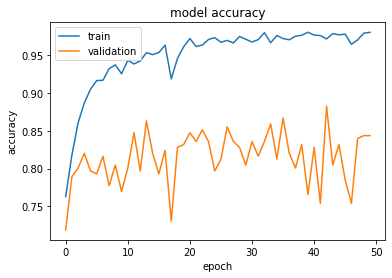

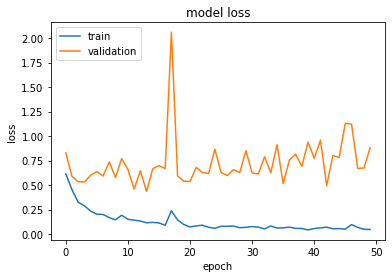

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
keras_model1 = "/Users/casiana/Documents/SkinCancer/outputN/SkinCancerI.pb"
keras.models.save_model(model,keras_model1)

INFO:tensorflow:Assets written to: /Users/casiana/Documents/SkinCancer/outputN/SkinCancerI.pb/assets


INFO:tensorflow:Assets written to: /Users/casiana/Documents/SkinCancer/outputN/SkinCancerI.pb/assets


In [26]:
keras.backend.clear_session()

In [27]:
converter = tf.lite.TFLiteConverter.from_saved_model(keras_model1)
tflite_model1 = converter.convert()
open("/Users/casiana/Documents/SkinCancer/outputN/model.tflite", "wb").write(tflite_model1)

2022-04-05 22:58:57.386720: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-05 22:58:57.386745: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-04-05 22:58:57.388100: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /Users/casiana/Documents/SkinCancer/outputN/SkinCancerI.pb
2022-04-05 22:58:57.420048: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-05 22:58:57.420062: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /Users/casiana/Documents/SkinCancer/outputN/SkinCancerI.pb
2022-04-05 22:58:57.512070: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-05 22:58:58.455049: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /Users/casiana/Documents/SkinCancer/outputN/SkinCancerI.pb
2022-04-05 22:

91346248